This notebook plots ROIs from minian along with max and min projections to aid in tracking neurons across days and eventually cross-registering.  Much of this will be built into TraceFC and/or NeuroPy modules, but the backbone is here for easy visualiation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os
import xarray as xr

if os.environ['SHELL'] == '/bin/zsh':
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/TraceFC/')
    sys.path.append('/Users/nkinsky/Documents/UM/GitHub/NeuroPy/')
elif os.environ['SHELL'] in ['/bin/bash', '/bin/sh']:
    sys.path.append('/data/GitHub/TraceFC/')
    sys.path.append('/data/GitHub/NeuroPy/')
%load_ext autoreload
%autoreload 2

from neuropy.plotting.ca_events import plot_pe_traces
from neuropy.io.minianio import MinianIO
from neuropy.core.ca_neurons import CaNeuronReg, CaNeurons, id_and_plot_reference_cells, detect_roi_centroid, PairwiseMap

# Put any user-defined functions for grabbing recording folder locations here
try:
    use_sd = True
    import session_directory as sd
except ModuleNotFoundError:
    use_sd = False
    print('No session_directory module found - enter recording folders by hand below')

Enter sessions you want to register here, either directly by path or by defining a project-specific lambda function to grab each directory

In [2]:
# list either session alias here if using session_directory or full path to recording folders
session_list = ['Habituation2', 'Training', 'Recall1']
animal = 'Rey'

dir_use = session_list if not use_sd else lambda session: sd.get_session_dir(animal, session)

In [3]:
# assemble data
careg = CaNeuronReg([MinianIO(basedir=dir_use(session)).trim_neurons(keep=['good', 'maybe_interneurons']) 
                     for session in session_list], alias=session_list)

Keeping 35589 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 15_57_51 folder.
Keeping 128405 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_44_15 folder.
Keeping 46637 good frames found in "good_frames_bool.npy" file


## First plot and identify reference cells that are active across both sessions specified below

<IPython.core.display.Javascript object>


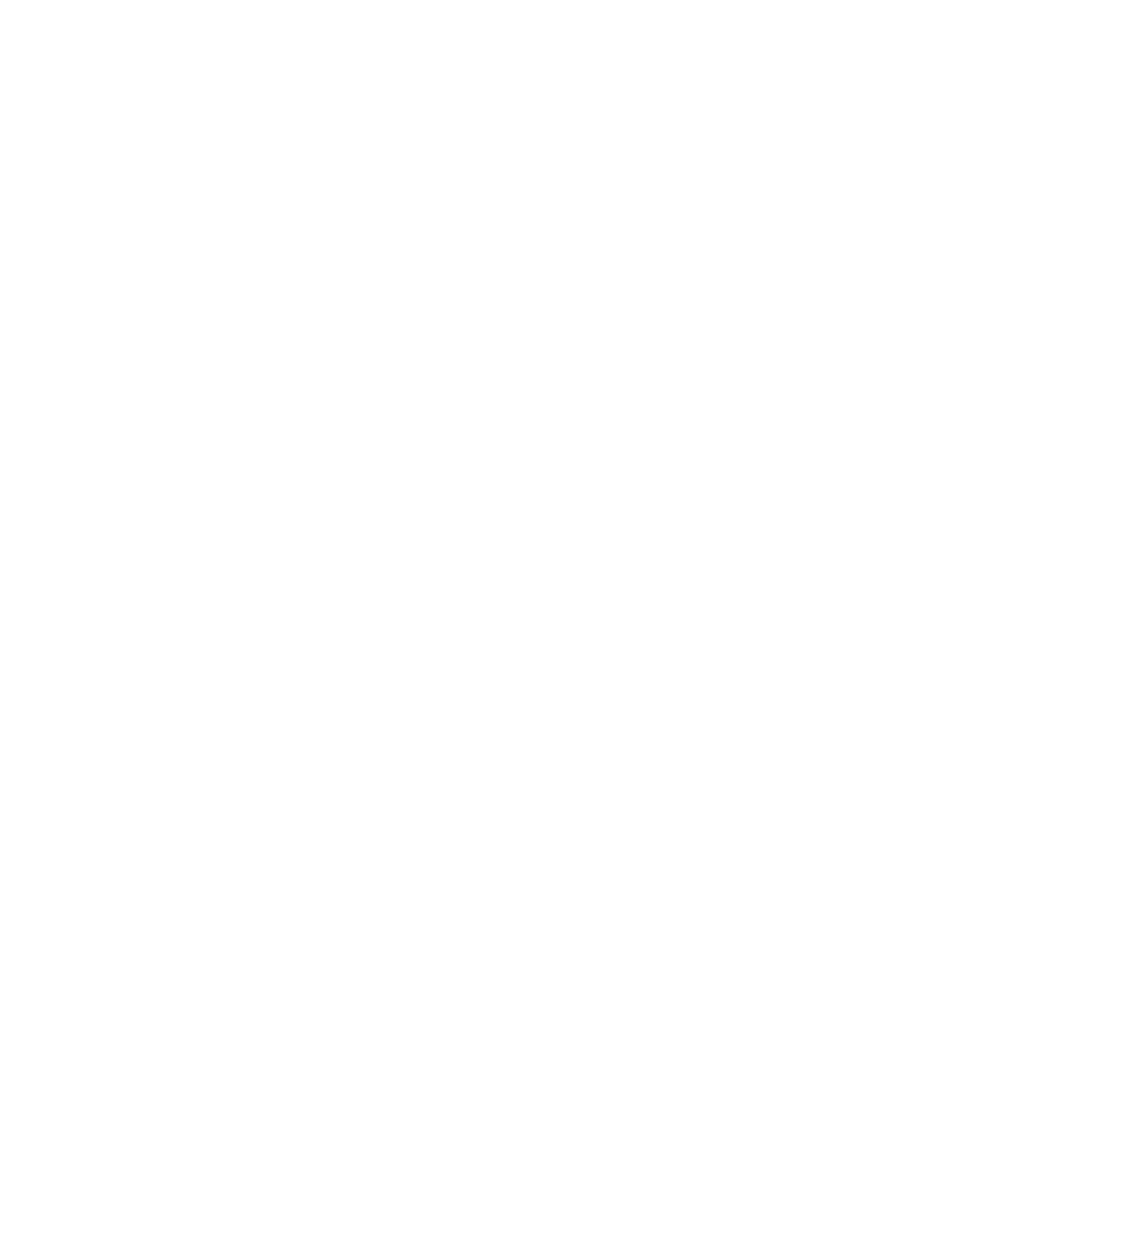

In [4]:
%matplotlib notebook
sesh1, sesh2 = 'Training', 'Recall1'
careg.plot_rois_across_sessions(sesh_plot=[sesh1, sesh2])

## Next merge (post-hoc) any cells that might be duplicates

In [5]:
sesh1_ind = np.where([alias == sesh1 for alias in careg.alias])[0][0]
sesh2_ind = np.where([alias == sesh2 for alias in careg.alias])[0][0]
careg.quick_merge(sesh1, unit_ids=[[13, 14], [18, 19]], in_place=True)
careg.quick_merge(sesh2, unit_ids=[[19, 20], [13, 14]], in_place=True)

<IPython.core.display.Javascript object>


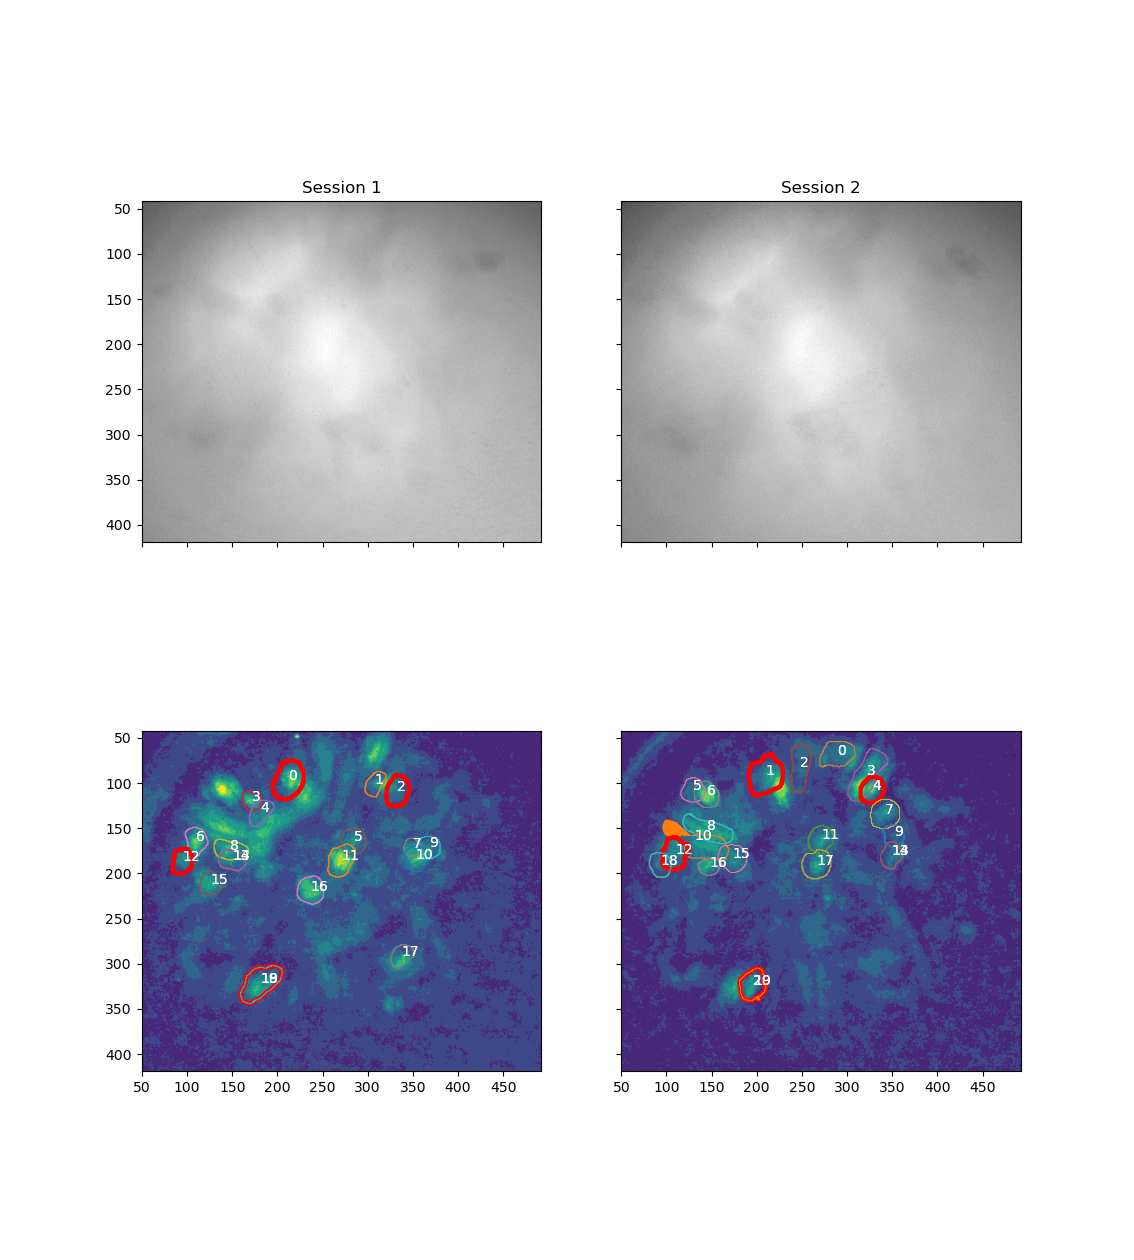


Enter (co-active) reference neurons from session 1 (space between) : 0 2 18 12

Enter (co-active) reference neurons from session 2 (space between) : 1 4 19 12


(<Figure size 1134x1260 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Session 1'}>,
         <AxesSubplot:title={'center':'Session 2'}>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

In [8]:
%matplotlib notebook
id_and_plot_reference_cells(careg.get_session(sesh1), careg.get_session(sesh2))

Rey Training-Recall coactive neuron log  
0 2 18 12  
1 4 19 12

In [9]:
## Match up neurons here
print('Session 1 neurons:')
print([a for a in range(careg.get_session(sesh1).A.shape[0])])
sesh1_sesh2_map = list(map(int,input("\nEnter session 2 neurons that match session 1 above (silent = -1) : ").
                      strip().split(",")))
map_df = pd.DataFrame({sesh1: np.arange(len(sesh1_sesh2_map)), sesh2: sesh1_sesh2_map})
map_df

Session 1 neurons:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Enter session 2 neurons that match session 1 above (silent = -1) : 1, 3, 4, -1, -1, 11, -1, 9, 10, -1, 13, 17, 12, 15, -1, 16, -1, -1, 19, -1


,Training,Recall1
0,0,1
1,1,3
2,2,4
3,3,-1
4,4,-1
5,5,11
6,6,-1
7,7,9
8,8,10
9,9,-1


### Check your work

In [10]:
map_df
coactive_bool = (map_df > -1).all(axis=1)
coactive_map = map_df[coactive_bool]
coactive_map

,Training,Recall1
0,0,1
1,1,3
2,2,4
5,5,11
7,7,9
8,8,10
10,10,13
11,11,17
12,12,12
13,13,15


# NRK todo:
make plot_overlaid function below and add into CaNeuronReg class to easily plot this elsewhere

<IPython.core.display.Javascript object>


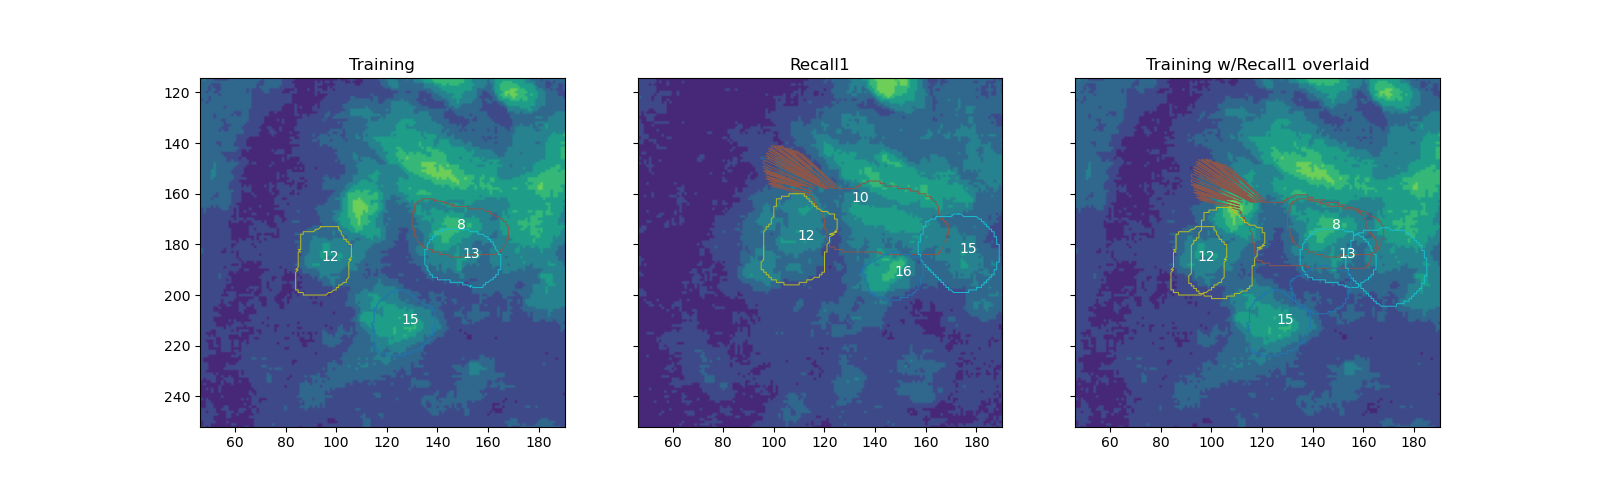

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

# Plot session 1
careg.get_session(sesh1).plot_rois(neuron_inds=coactive_map[sesh1], label=True, ax=ax[0])

# Plot session 2
careg.get_session(sesh2).plot_rois(neuron_inds=coactive_map[sesh2], label=True, ax=ax[1])
[a.set_title(sesh) for a, sesh in zip(ax[:2], (sesh1, sesh2))];

# Calculate delta center-of-mass for all mapped neurons
delta_com = careg.get_session(sesh1).roi_com(neuron_inds=coactive_map[sesh1]) - careg.get_session(sesh2).roi_com(neuron_inds=coactive_map[sesh2])

# Plot cells overlaid on top of one another with shift applied
_, _, _ = careg.get_session(sesh1).plot_rois(neuron_inds=coactive_map[sesh1], label=True, ax=ax[2])
ax[2].set_title(f'{sesh1} w/{sesh2} overlaid')
ax[2].set_prop_cycle(None)  # restart automatic coloring so that it session 2 colors match session 1 colors
_, _, roi_edges = careg.get_session(sesh2).plot_rois(neuron_inds=coactive_map[sesh2], plot_max=False,
                                                            plot_cell_id=False, label=True, ax=ax[2])
careg.shift_roi_edges(roi_edges, delta_com)

## Adjust any wrongly registered cells by hand here

In [12]:
map_df.iloc[15][1] = -1
map_df

,Training,Recall1
0,0,1
1,1,3
2,2,4
3,3,-1
4,4,-1
5,5,11
6,6,-1
7,7,9
8,8,10
9,9,-1


### Now save the map between sessions and check to make sure it saved properly

In [16]:
from neuropy.core.ca_neurons import PairwiseMap
pw_map = PairwiseMap(careg, map_df, animal, sesh1, sesh2)

savename = careg.get_session(sesh1).basedir / f'map_{sesh1}_{sesh2}.pwmap.npy'
np.save(savename, pw_map, allow_pickle=True)

In [22]:
# Last, check that things saved nicely
pw_map_check = np.load(savename, allow_pickle=True).item()
(pw_map_check.map == map_df).all()

Training    True
Recall1     True
dtype: bool

## Last save a copy of this notebook for bookkeeping

In [23]:
import ipynbname
import shutil
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

nb_copy_savename = careg.get_session(sesh1).basedir / f'{animal}_{sesh1}_{sesh2}_manual_cell_reg.ipynb'
shutil.copy(str(nb_path), str(nb_copy_savename))

'/data2/Trace_FC/Recording_Rats/Rey/2022_05_09_training/Rey_Training_Recall1_manual_cell_reg.ipynb'